In [1]:
from math import pi

import matplotlib.pyplot as plt
import torch
from scipy.io import loadmat

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft import ADSTFT, DSTFT

device = "cpu" # "cuda" if torch.cuda.is_available() else "cpu"
print(device, torch.__version__)
torch.manual_seed(1802);

cpu 2.2.1


In [2]:
mat = loadmat("../data/fan_flutter.mat")["x"]
x = torch.from_numpy(mat).float().to(device)[:, 4_000:10_000]

In [3]:
stride = 50
support = 1_000
epochs = 1_00
lr = 100
win_min = 100
threshold = 5
patience = 9
win_length = 500
factor = 0.1

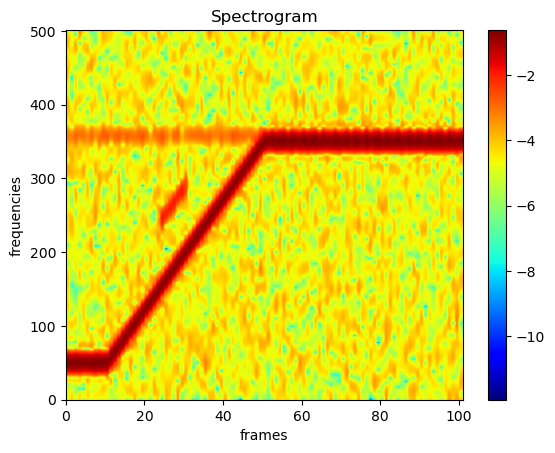

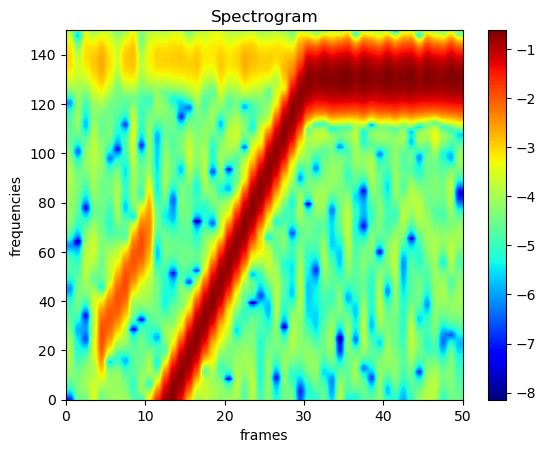

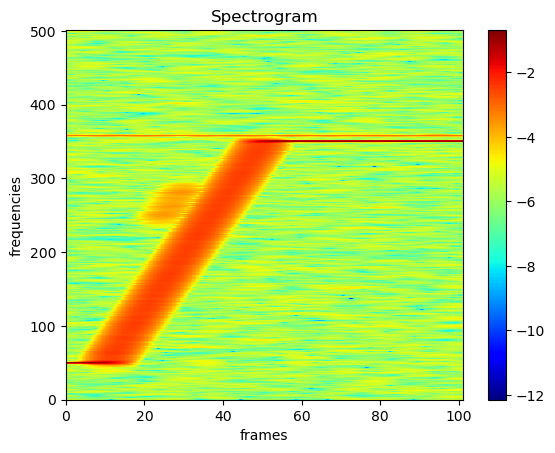

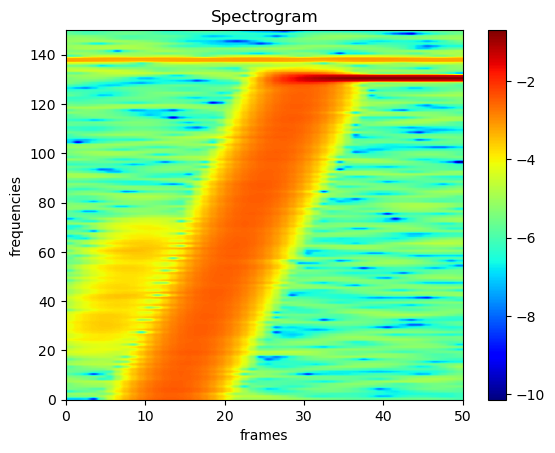

In [4]:
for winlen in [100, 1_000]:
    dstft = DSTFT(
        x,
        win_length=winlen,
        support=support,
        stride=stride,
        win_requires_grad=False,
        stride_requires_grad=False,
        win_p=None,
        stride_p=None,
    )
    spec, stft = dstft(x)
    dstft.plot(spec, weights=False, wins=False, bar=True)
    dstft.plot(spec[:, 220:370, 20:70], x, bar=True, wins=False, weights=False)

In [5]:
def entropy_loss(x):
    x1 = torch.reshape(x, (x.shape[0], -1))  # B, N
    probs = torch.div(x1.T, x1.sum(dim=-1)).T  # B, N
    entropy = -(
        probs * torch.clamp(torch.log(probs), min=torch.finfo(x.dtype).min)
    ).sum(
        dim=-1,
    )  # B
    return entropy.mean()


def kurtosis_loss(x):
    kur = x.pow(4).mean(dim=1) / x.pow(2).mean(dim=1).pow(2)  # B, T
    return kur


def kurtosis_loss2(x):
    kur = x.pow(4).mean() / x.pow(2).mean().pow(2)  # B, T
    return kur

Classical STFT : Single window length DSTFT

/home/maxime/miniforge3/envs/dstft_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


nb of epochs: 9, window length: 313.4


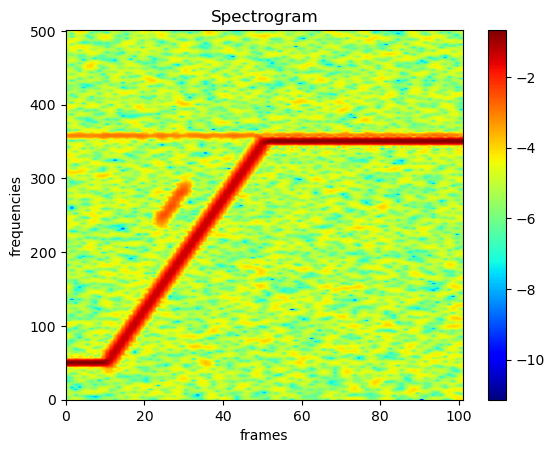

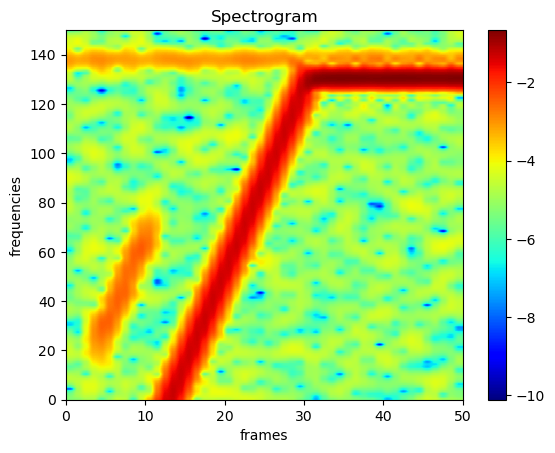

In [6]:
dstft = DSTFT(
    x,
    win_length=win_length,
    support=support,
    stride=stride,
    win_requires_grad=True,
    stride_requires_grad=False,
    win_p=None,
    stride_p=None,
)
params = [{"params": dstft.win_length, "lr": lr}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=opt, mode="min", factor=factor, patience=patience, verbose=True,
)

min_err = 100
min_win = 0

for epoch in range(epochs):
    opt.zero_grad()
    spec, stft = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)

    if err < min_err:
        min_err = err
        min_win = dstft.win_length.item()

    if opt.param_groups[0]["lr"] < threshold:
        break

print(f"nb of epochs: {epoch}, window length: {dstft.win_length.item():.1f}")
dstft.plot(spec, x, bar=True, wins=False, weights=False)
dstft.plot(spec[:, 220:370, 20:70], x, bar=True, wins=False, weights=False)

Time-varying window length DSTFT

9


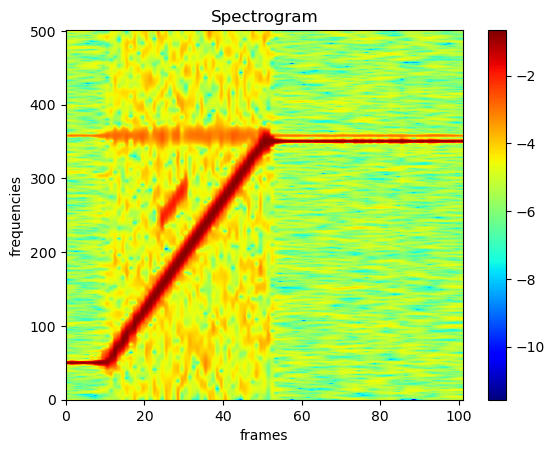

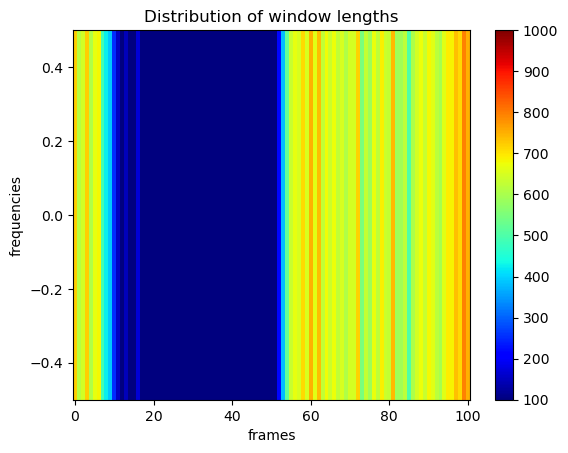

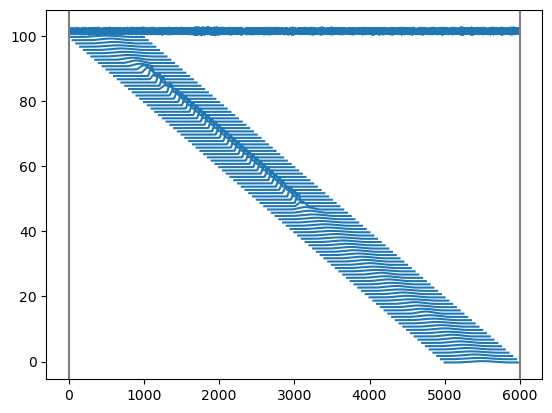

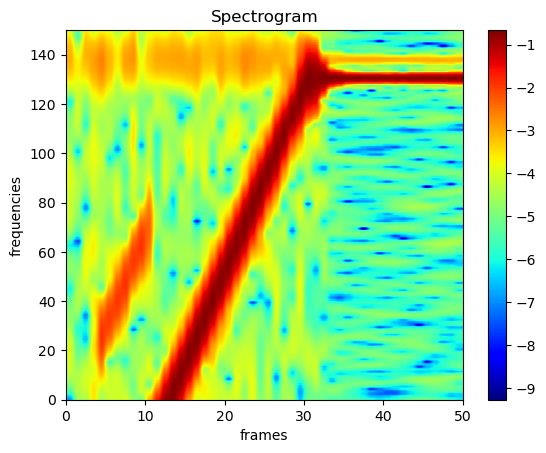

In [7]:
dstft = DSTFT(
    x,
    win_length=win_length,
    support=support,
    stride=stride,
    win_requires_grad=True,
    stride_requires_grad=False,
    win_p="t",
    win_min=win_min,
)
params = [{"params": dstft.win_length, "lr": lr}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=opt, mode="min", factor=factor, patience=patience, verbose=True,
)

for epoch in range(epochs):
    opt.zero_grad()
    spec, stft = dstft(x)
    err = (
        entropy_loss(spec)
        + 0.001
        * (dstft.actual_win_length.diff(dim=1).pow(2) + torch.finfo(x.dtype).eps)
        .sqrt()
        .mean()
    )
    err.backward()
    opt.step()
    sch.step(err)

    if opt.param_groups[0]["lr"] < threshold:
        break

print(epoch)
dstft.plot(spec, x, bar=True, wins=True)
dstft.plot(spec[:, 220:370, 20:70], x, bar=True, wins=False, weights=False)

Adaptive DSTFT: time-frequency varying window length DSTFT

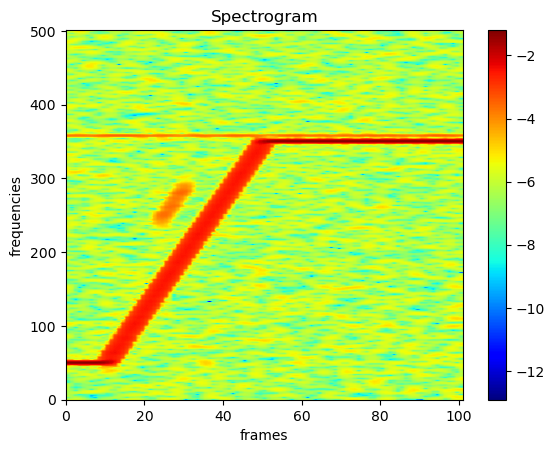

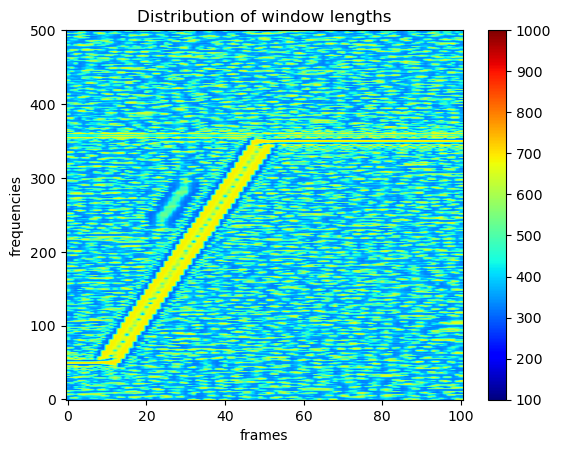

torch.Size([501, 101])
nb of epochs: 9


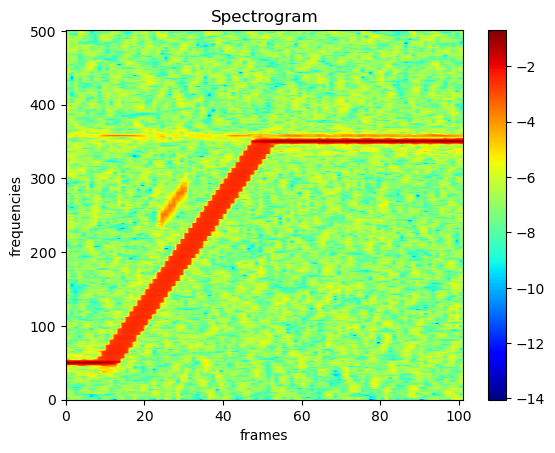

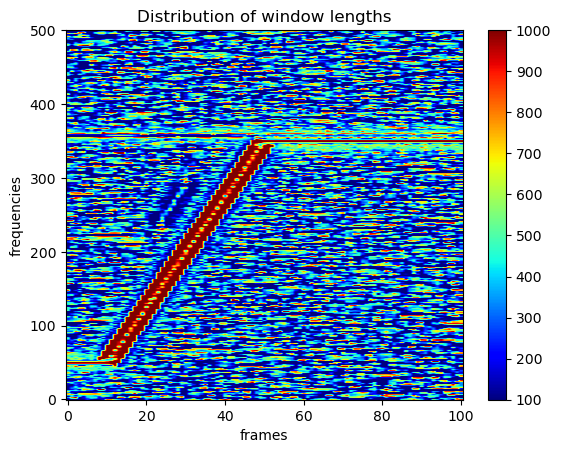

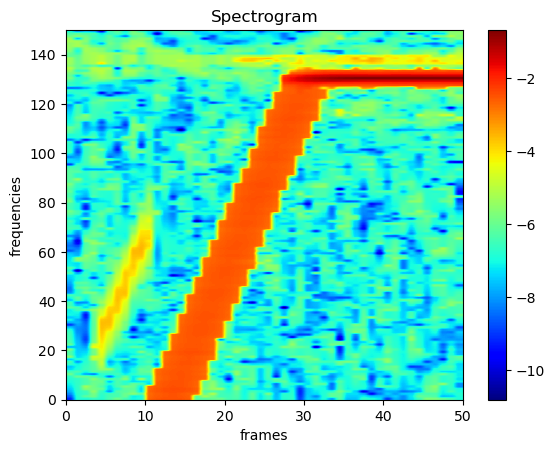

In [8]:
dstft = ADSTFT(
    x,
    win_length=win_length,
    support=support,
    stride=stride,
    win_requires_grad=True,
    stride_requires_grad=False,
    win_p="tf",
    win_min=win_min,
)
# dstft.win_length.data = dstft.win_min + (
#    dstft.win_max - dstft.win_min
# ) * torch.rand(dstft.win_length.size(), device=device)

params = [{"params": dstft.win_length, "lr": lr}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=opt, mode="min", factor=factor, patience=patience, verbose=True,
)


for epoch in range(epochs):
    opt.zero_grad()
    spec, stft = dstft(x)
    err = entropy_loss(spec)  # 1_000 / kurtosis_loss2(spec).mean() #
    err.backward()
    opt.step()
    sch.step(err)

    if opt.param_groups[0]["lr"] < 20:
        break

    if epoch % 100 == 1:
        dstft.plot(spec, x, bar=True, wins=False)

print(dstft.win_length.shape)

print(f"nb of epochs: {epoch}")
dstft.plot(spec, x, bar=True, wins=False)
dstft.plot(spec[:, 220:370, 20:70], x, bar=True, wins=False, weights=False)

/home/maxime/miniforge3/envs/dstft_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


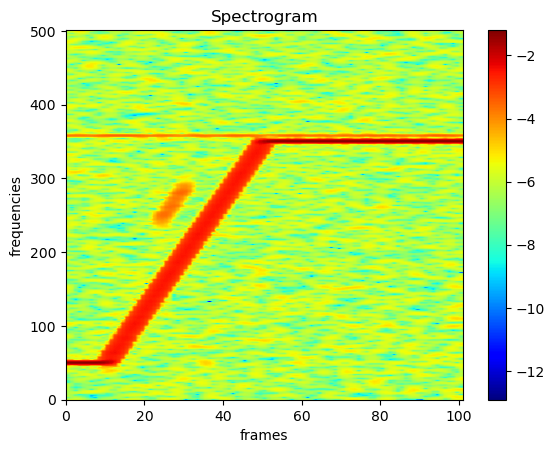

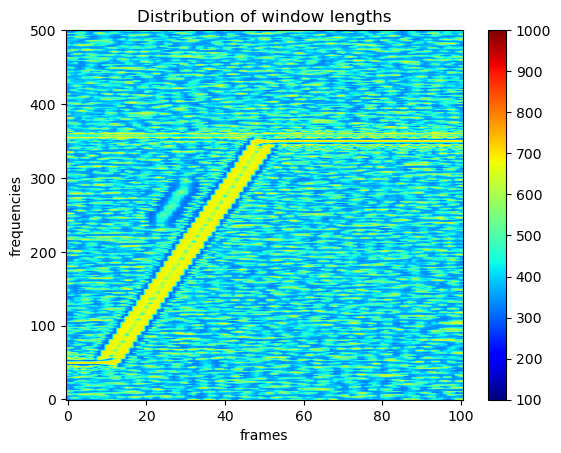

In [9]:
dstft = ADSTFT(
    x,
    win_length=win_length,
    support=support,
    stride=stride,
    win_requires_grad=True,
    stride_requires_grad=False,
    win_p="tf",
    win_min=win_min,
)
# dstft.win_length.data = dstft.win_min + (
#    dstft.win_max - dstft.win_min
# ) * torch.rand(dstft.win_length.size(), device=device)

params = [{"params": dstft.win_length, "lr": lr}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=opt, mode="min", factor=factor, patience=patience, verbose=True,
)


for epoch in range(epochs):
    opt.zero_grad()
    spec, stft = dstft(x)
    err = (
        entropy_loss(spec)
        + 0.001  # *torch.rand(1, device=device) #0.01  # .004 1_000 / kurtosis_loss2(spec).mean()
        * (
            dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2)
            + dstft.actual_win_length.diff(dim=1)[:-1].pow(2)
            + torch.finfo(x.dtype).eps
        )
        .sqrt()
        .mean()
    )  # entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)

    if opt.param_groups[0]["lr"] < 1:
        break

    if epoch % 100 == 1:
        dstft.plot(spec, x, bar=True, wins=False)


print(f"nb of epochs: {epoch}")
dstft.plot(spec, x, bar=True, wins=False)
dstft.plot(spec[:, 220:370, 20:70], x, bar=True, wins=False, weights=False)

Time-varying window and hop lengths

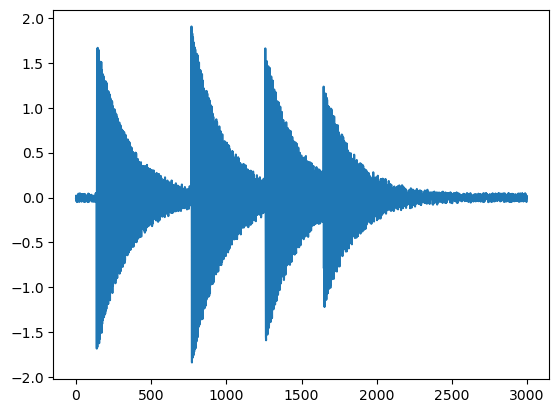

In [ ]:
fs = 1e3
t = torch.arange(0, 3, 1 / fs)
L = t.shape[0]
mark_list = [138, 768, 1259, 1647]
index_impulse = torch.tensor(mark_list).long()

alpha = 5
f = torch.ones_like(t)
f[:768] = 250 * f[:768]
f[768:1259] = 200 * f[768:1259]
f[1259:1647] = 100 * f[1259:1647]
f[1647:] = 300 * f[1647:]
x = torch.sin(torch.cumsum(2 * pi * f, dim=0) / fs)
y = torch.zeros_like(x)
y[index_impulse] = 1 + torch.rand(index_impulse.shape)
z = torch.exp(-t * alpha)
z1 = torch.fft.ifft(torch.fft.fft(z) * torch.fft.fft(y))
x = x * z1.real + 0.1 * torch.rand(f.shape)
x = x - x.mean()
x = x[None, :].to(device)
plt.plot(x[0].cpu())

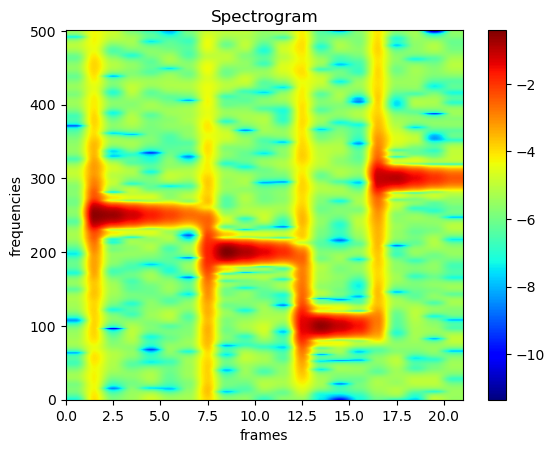

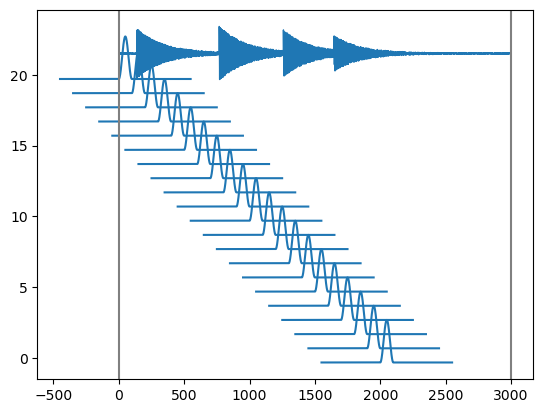

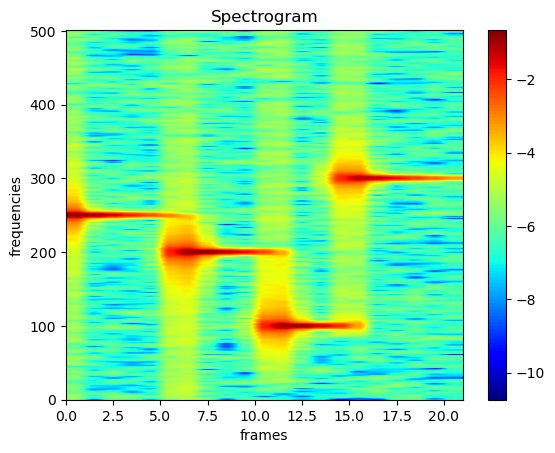

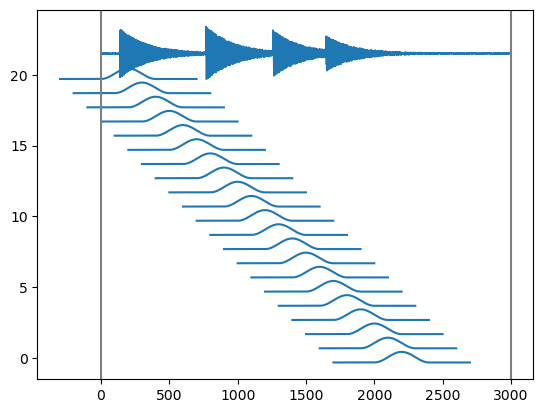

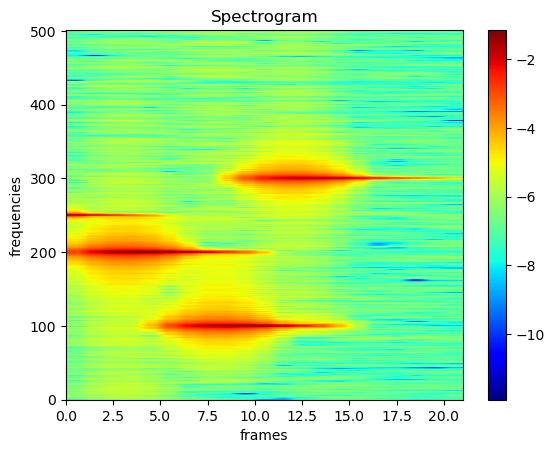

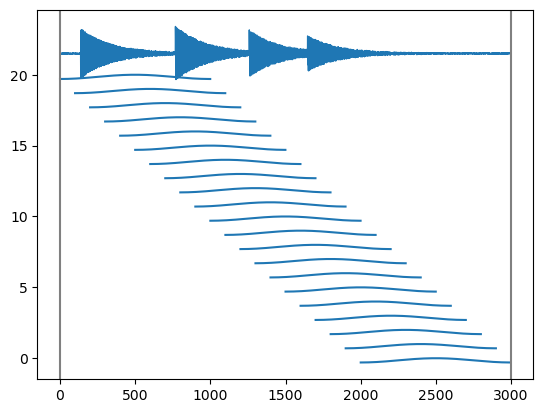

In [ ]:
for win_length in [100, 400, 1_000]:
    dstft = DSTFT(
        x,
        win_length=win_length,
        support=1_000,
        stride=100,
        win_requires_grad=False,
        stride_requires_grad=False,
        win_p="t",
        stride_p=None,
        first_frame=True,
    )
    spec, *_ = dstft(x)
    dstft.plot(spec, x, weights=False, bar=True)

time-varying hop length

1495


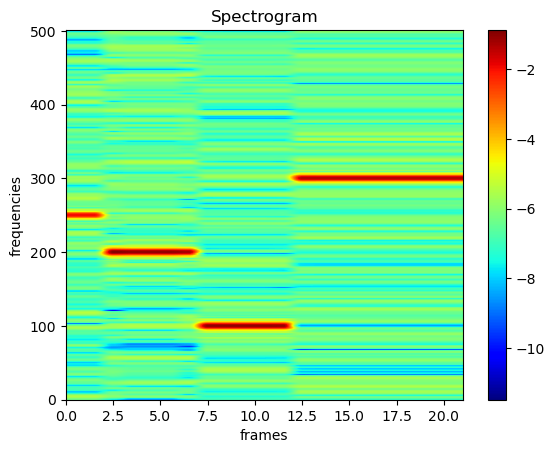

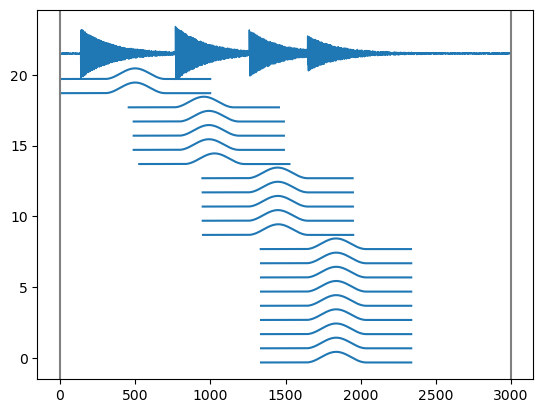

In [ ]:
dstft = DSTFT(
    x,
    win_length=400,
    support=1_000,
    stride=100,
    win_requires_grad=False,
    stride_requires_grad=True,
    win_p="t",
    stride_p="t",
    win_min=100,
)
params = [{"params": dstft.parameters(), "lr": 1.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=opt, mode="min", factor=factor, patience=99,
)

for epoch in range(10_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean()
    err.backward()
    opt.step()
    sch.step(err)

    if opt.param_groups[0]["lr"] < 0.1:
        break

print(epoch)
dstft.plot(spec, x, bar=True, weights=False)

Time-varying window and hop length

1317


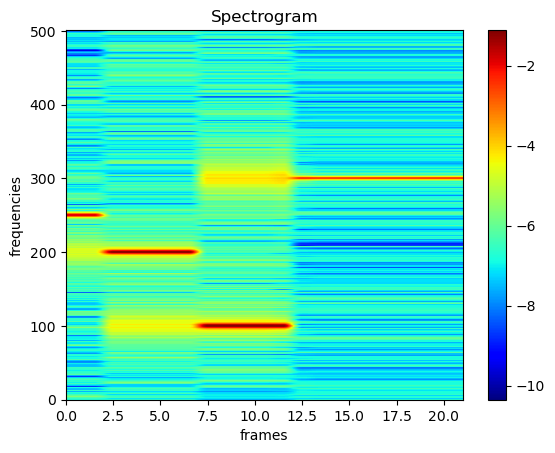

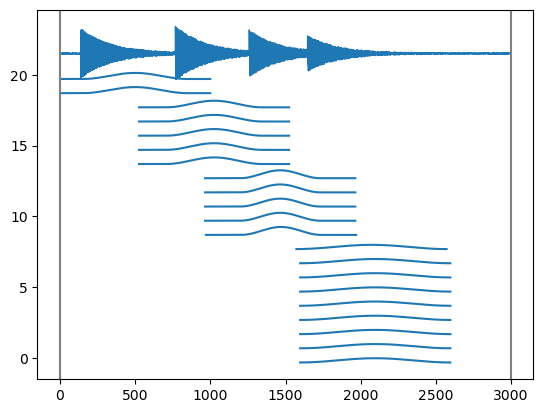

In [ ]:
dstft = DSTFT(
    x,
    win_length=400,
    support=1_000,
    stride=100,
    win_requires_grad=True,
    stride_requires_grad=True,
    win_p="t",
    stride_p="t",
    win_min=100,
)
params = [{"params": dstft.parameters(), "lr": 1.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=opt, mode="min", factor=factor, patience=patience, verbose=True,
)

for epoch in range(10_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean()
    err.backward()
    opt.step()
    sch.step(err)

    if opt.param_groups[0]["lr"] < 0.1:
        break

print(epoch)
dstft.plot(spec, x, bar=True, weights=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def stft(x, wsize, hopsize):
    n = len(x)
    window = np.hanning(wsize)
    frames = np.array([x[i:i+wsize] for i in range(0, n-wsize+1, hopsize)])
    X = np.fft.fft(frames, axis=1)
    return X

# Signal sinusoïdal avec changement de fréquence
t = np.linspace(0, 1, 1024)
x = np.sin(2*np.pi*5*t) + np.sin(2*np.pi*10*t[512:])

# Paramètres STFT
wsize = 256
hopsize = 128

# Calcul du spectrogramme
X = stft(x, wsize, hopsize)

# Affichage du spectrogramme
plt.imshow(np.abs(X), extent=[0, t[-1], 0, 5000], aspect='auto')
plt.ylabel('Fréquence (Hz)')
plt.xlabel('Temps (s)')
plt.show()

# Critère d'optimisation :
# - Minimisation de l'erreur quadratique moyenne entre le signal reconstruit et le signal original




# Cas 2 : Fenêtre variable en fonction de la fréquence**


def stft_var_freq(x, wsize_min, wsize_max, hopsize):
    n = len(x)
    wsize = np.linspace(wsize_min, wsize_max, n)
    window = np.hanning(wsize.astype(int))
    frames = np.array([x[i:i+int(wsize[i])] for i in range(0, n-int(wsize_max)+1, hopsize)])
    X = np.fft.fft(frames, axis=1)
    return X

# Signal chirp
t = np.linspace(0, 1, 1024)
x = np.sin(2*np.pi*t**2)

# Paramètres STFT
wsize_min = 64
wsize_max = 256
hopsize = 128

# Calcul du spectrogramme
X = stft_var_freq(x, wsize_min, wsize_max, hopsize)

# Affichage du spectrogramme
plt.imshow(np.abs(X), extent=[0, t[-1], 0, 5000], aspect='auto')
plt.ylabel('Fréquence (Hz)')
plt.xlabel('Temps (s)')
plt.show()

# Critère d'optimisation :
# - Maximisation de la résolution fréquentielle pour les fréquences basses
# - Maximisation de la résolution temporelle pour les fréquences élevées

#**Cas 3 : Fenêtre variable en temps et fréquence**


def stft_var_time_freq(x, wsize_min, wsize_max, hopsize_min, hopsize_max):
    n = len(x)
    wsize = np.linspace(wsize_min, wsize_max, n)
    hopsize = np.linspace(hopsize_min, hopsize_max, n)
    window = np.hanning(wsize.astype(int))
    frames = np.array([x[i:i+int(wsize[i])] for i in range(0, n-int(wsize_max)+1, int(hopsize[i]))])
    X = np.fft.fft(frames, axis=1)
    return X

# Signal avec transitoires
t = np.linspace(0, 1, 1024)
x = np.sin(2*np.pi*5*t) + np.sin(2*np.pi*10*t[512:]) + np.random.randn(1024)

# Paramètres STFT
wsize_min = 64
wsize_max = 256
hopsize_min = 32
hopsize_max = 128

# Calcul du spectrogramme
X = stft_var_time_freq(x, w

SyntaxError: incomplete input (3774061437.py, line 90)